# Doublet Panel Method in Different Kinds of Airfoils with Different Attack Angles

In [1]:
import os
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
# display the figures in the Notebook
%matplotlib inline

In [138]:
def NACA(naca,c,n):
    
    H=float(naca[0])/100
    p=float(naca[1])/10
    t1=float(naca[2])
    t2=float(naca[3])
    T=10*t1+t2
    T=T/100

    beta=numpy.linspace(0,numpy.pi,n+1)
    xc=numpy.zeros(numpy.size(beta))
    for i in range(n+1):
        xc[i]=c*(1-0.5*(1-math.cos(beta[i])))
    
    thdis=numpy.zeros(numpy.size(xc))
    
    for i in range(n+1):
        thdis[i]=5*T*c*(0.2969*math.sqrt(xc[i]/c)-0.126*xc[i]/c-0.3537*(xc[i]/c)**2 +0.2843*(xc[i]/c)**3-0.1015*(xc[i]/c)**4)
    
    camberline=numpy.zeros(numpy.size(beta))
    
    if(p!=0.0 and H!=0.0):
        for i in range(n+1):
            if(xc[i] <= p*c):
                camberline[i]=(H/p**2)*xc[i]*(2*p-xc[i]/c)
            elif(xc[i] > p*c):
                camberline[i]=(H/(1-p)**2)*(c-xc[i])*(1+xc[i]/c-2*p)
    
    xu=numpy.zeros(numpy.size(xc))
    xl=numpy.zeros(numpy.size(xc))
    zu=numpy.zeros(numpy.size(xc))
    zl=numpy.zeros(numpy.size(xc))
    tht=numpy.zeros(numpy.size(xc))
                
    if(p==0 or H==0):
        xu=xc
        zu=thdis
        xl=xc
        zl=-thdis
    else:
        for i in range(n+1):
            if(xc[i] <= p*c):
                tht[i]=math.atan((2*H/p)*(-xc[i]/(c*p)+1))
            elif(xc[i] > p*c):
                tht[i]=math.atan((2*H/(1-p**2))*(p-(xc[i]/c)))
            xu[i]=xc[i]-thdis[i]*math.sin(tht[i])
            zu[i]=camberline[i]+thdis[i]*math.cos(tht[i])
            xl[i]=xc[i]+thdis[i]*math.sin(tht[i])
            zl[i]=camberline[i]-thdis[i]*math.cos(tht[i])
        
        
    X=numpy.zeros((n+n+1,1),dtype=float)
    Z=numpy.zeros((n+n+1,1),dtype=float)
    for i in range(n+1):
        X[i]=xl[i]
        Z[i]=zl[i]
    

    for i in range(n):
        X[n+1+i]=xu[n-i-1]
        Z[n+1+i]=zu[n-i-1]
        
    return X,Z

In [139]:
class Panel:
  
    def __init__(self, xa, ya, xb, yb):
  
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        self.al=math.atan2((ya-yb),(xb-xa)) # Panel angle of attack
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.                             # panel doublet strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

In [140]:
def define_panels(xp, yp, N):
    panel = numpy.empty(N, dtype=object)
    for i in range(N):
        if(i==N-1):
            panel[i]=Panel(xp[-1],yp[-1],100000,yp[-1])#Adding wake panel at the end
        else:
            panel[i]=Panel(xp[i],yp[i],xp[i+1],yp[i+1])
    
    return panel

# 0012 airfoil with different attack angles
# 2212 airfoil with different attack angles
# 4412 airfoil with different attack angles

In [141]:
n=40 # Number of Panels per surface
c=1  # Chord Length
#naca=[0,0,1,2]
#naca=[2,2,1,2]
naca=[4,4,1,2]
xp,yp=NACA(naca,c,n)
N=numpy.size(xp)
panels = define_panels(xp, yp, N)   # discretizes of the geometry into panels

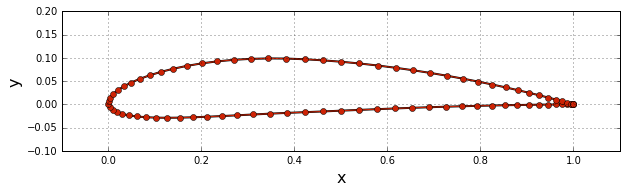

In [142]:
# plot the geometry and the panels
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(xp, yp, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.2);

In [143]:
def PHICD(sigma,xc,yc,panel):
    

    xR=math.cos(panel.al)*(panel.xb-panel.xa)-math.sin(panel.al)*(panel.yb-panel.ya) 
    x=math.cos(panel.al)*(xc-panel.xa)-math.sin(panel.al)*(yc-panel.ya)
    y=math.sin(panel.al)*(xc-panel.xa)+math.cos(panel.al)*(yc-panel.ya)
    
    #Calculating Phi
    phi=-(sigma/(2*math.pi))*((math.atan2(y,x-xR))-(math.atan2(y,x)));
    
    return phi

In [144]:
class freestream:
    def __init__(self,qinf,al):
        self.qinf=qinf # Resultant velocity
        self.alpha=al*math.pi/180 # Angle of Attack
        self.uinf=qinf*math.cos(al*math.pi/180) # X-Velocity
        self.vinf=qinf*numpy.sin(al*math.pi/180) # Y- Velocity

In [145]:
# define and creates the object freestream
qinf = 1.0                                # freestream spee                                # angle of attack (in degrees)
#alpha = 5.0 
#alpha = 10.0 
alpha = 15.0 
freestream = freestream(qinf, alpha)      # instantiation of the object freestream

In [146]:
def doublet_contribution_normal(panels): 
   
    A=numpy.zeros((N,N),dtype=float) # Array for influence coeffcients
    
    for i, panel in enumerate(panels):
        for j, panel in enumerate(panels):
            if (i==j):
                A[i][j]=0.5
            else:
                A[i][j]=PHICD(1,panels[i].xc,panels[i].yc,panels[j])
    # Explicit Kutta Condition
    A[N-1][0]=1
    A[N-1][N-2]=-1
    A[N-1][N-1]=1
    
    return A

def build_rhs(panels, freestream):
    
    b = numpy.zeros((N,1),dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.uinf*panels[i].xc-freestream.vinf*panels[i].yc
    
    return b

In [147]:
A = doublet_contribution_normal(panels)                    # compute the singularity matrix
b = build_rhs(panels, freestream)           # compute the freestream RHS


In [148]:

sigma=numpy.linalg.solve(A,b) # Solving to get doublet strengths

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

In [149]:
def compute_pressure_coefficient(panels):
    
    Cl=0
    for i, panel in enumerate(panels):
        if i==0:
            R = math.sqrt((panel[1].xc-panel[0].xc)**2+(panel[1].yc-panel[0].yc)**2);
            panel[i].vt= (sigma[1]-sigma[0])/R;
        elif i==N-2:
            R = math.sqrt((panel[N-2].xc-panel[N-3].xc)**2+(panel[N-2].yc-panel[N-3].yc)**2);
            panel[i].vt= (sigma[N-2]-sigma[N-3])/R;
        else:
            R = math.sqrt((panel[i+1].xc-panel[i-1].xc)**2+(panel[i+1].yc-panel[i-1].yc)**2);
            panel[i].vt= (sigma[i+1]-sigma[i-1])/R;
        
        panel[i].cp=1-((panel[i].Vt/qinf)**2)
        Cl=Cl-panel[i].vt*R
    
    return Cl

(-4, 4.0)

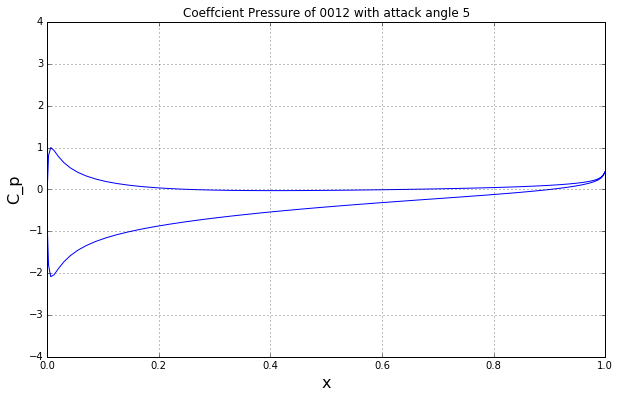

In [36]:
pxc=numpy.empty(N-1,dtype=float)
pcp=numpy.empty(N-1,dtype=float)
for i in range(N-1):
    pxc[i]=panel[i].xc
    pcp[i]=panel[i].cp
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.plot(pxc,pcp)
pyplot.gca().invert_yaxis()
pyplot.title('Coeffcient Pressure of 0012 with attack angle 5')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel("C_p", fontsize=16)
pyplot.xlim(0,1)
pyplot.ylim(-4, 4.0)

(-6, 4.0)

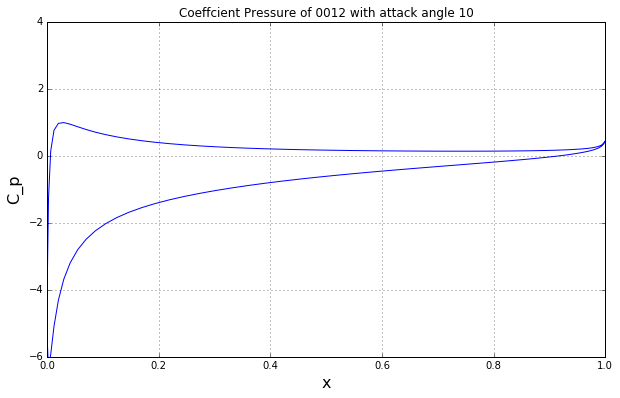

In [51]:
pxc=numpy.empty(N-1,dtype=float)
pcp=numpy.empty(N-1,dtype=float)
for i in range(N-1):
    pxc[i]=panel[i].xc
    pcp[i]=panel[i].cp
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.plot(pxc,pcp)
pyplot.gca().invert_yaxis()
pyplot.title('Coeffcient Pressure of 0012 with attack angle 10')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel("C_p", fontsize=16)
pyplot.xlim(0,1)
pyplot.ylim(-6, 4.0)

(-4, 4.0)

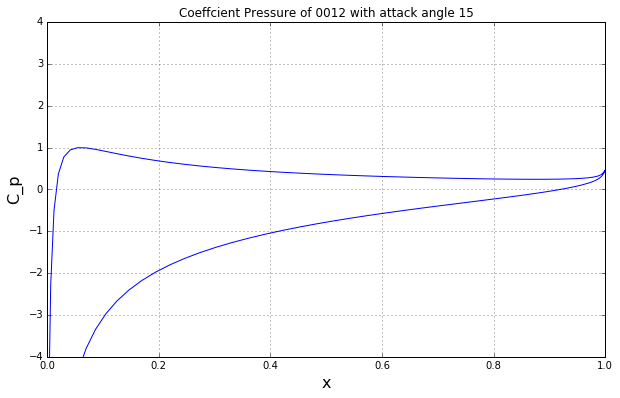

In [65]:
pxc=numpy.empty(N-1,dtype=float)
pcp=numpy.empty(N-1,dtype=float)
for i in range(N-1):
    pxc[i]=panel[i].xc
    pcp[i]=panel[i].cp
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.plot(pxc,pcp)
pyplot.gca().invert_yaxis()
pyplot.title('Coeffcient Pressure of 0012 with attack angle 15')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel("C_p", fontsize=16)
pyplot.xlim(0,1)
pyplot.ylim(-4, 4.0)

(-4, 4.0)

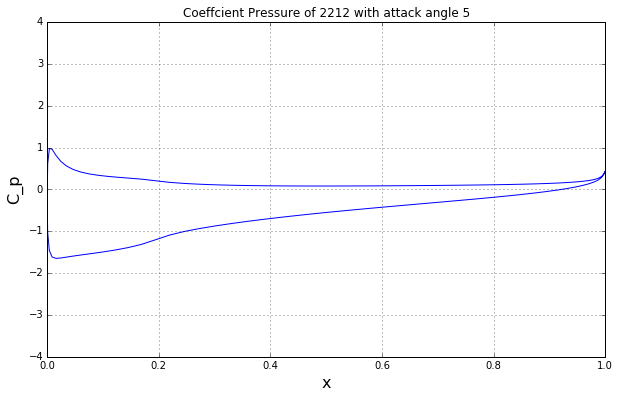

In [79]:
pxc=numpy.empty(N-1,dtype=float)
pcp=numpy.empty(N-1,dtype=float)
for i in range(N-1):
    pxc[i]=panel[i].xc
    pcp[i]=panel[i].np
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.plot(pxc,pcp)
pyplot.gca().invert_yaxis()
pyplot.title('Coeffcient Pressure of 2212 with attack angle 5')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel("C_p", fontsize=16)
pyplot.xlim(0,1)
pyplot.ylim(-4, 4.0)

(-6, 4.0)

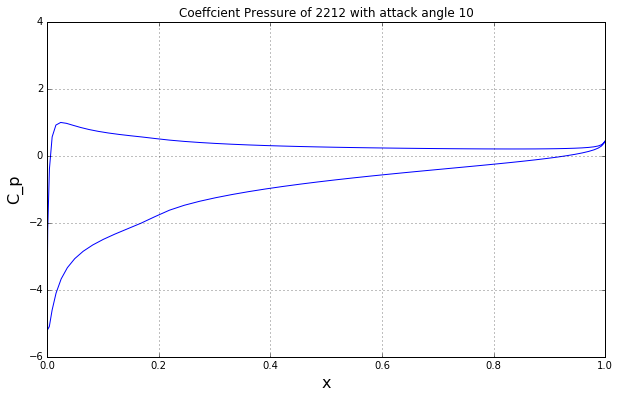

In [93]:
pxc=numpy.empty(N-1,dtype=float)
pcp=numpy.empty(N-1,dtype=float)
for i in range(N-1):
    pxc[i]=panel[i].xc
    pcp[i]=panel[i].cp
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.plot(pxc,pcp)
pyplot.gca().invert_yaxis()
pyplot.title('Coeffcient Pressure of 2212 with attack angle 10')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel("C_p", fontsize=16)
pyplot.xlim(0,1)
pyplot.ylim(-6, 4.0)

(-6, 4.0)

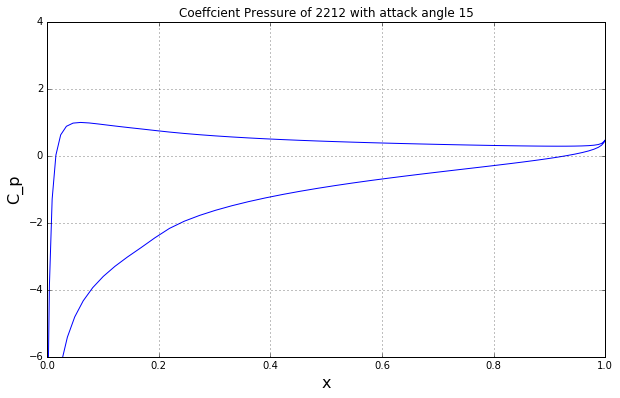

In [107]:
pxc=numpy.empty(N-1,dtype=float)
pcp=numpy.empty(N-1,dtype=float)
for i in range(N-1):
    pxc[i]=panel[i].xc
    pcp[i]=panel[i].cp
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.plot(pxc,pcp)
pyplot.gca().invert_yaxis()
pyplot.title('Coeffcient Pressure of 2212 with attack angle 15')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel("C_p", fontsize=16)
pyplot.xlim(0,1)
pyplot.ylim(-6, 4.0)

(-4, 4.0)

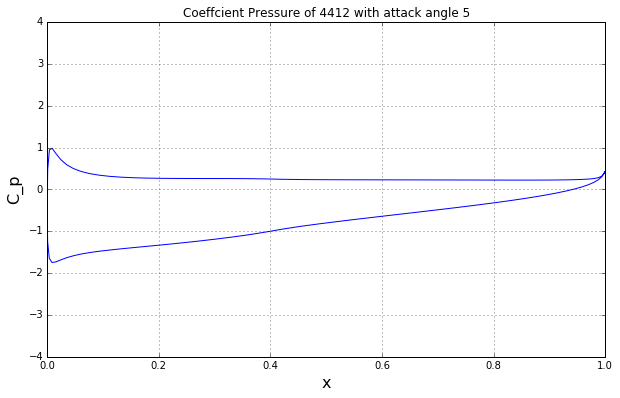

In [121]:
pxc=numpy.empty(N-1,dtype=float)
pcp=numpy.empty(N-1,dtype=float)
for i in range(N-1):
    pxc[i]=panel[i].xc
    pcp[i]=panel[i].cp
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.plot(pxc,pcp)
pyplot.gca().invert_yaxis()
pyplot.title('Coeffcient Pressure of 4412 with attack angle 5')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel("C_p", fontsize=16)
pyplot.xlim(0,1)
pyplot.ylim(-4, 4.0)

(-6, 4.0)

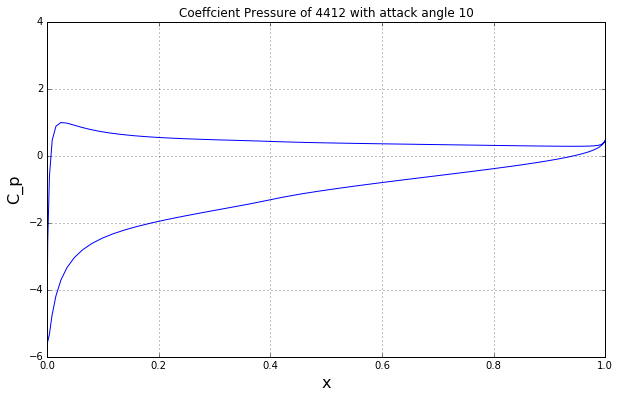

In [136]:
pxc=numpy.empty(N-1,dtype=float)
pcp=numpy.empty(N-1,dtype=float)
for i in range(N-1):
    pxc[i]=panel[i].xc
    pcp[i]=panel[i].cp
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.plot(pxc,pcp)
pyplot.gca().invert_yaxis()
pyplot.title('Coeffcient Pressure of 4412 with attack angle 10')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel("C_p", fontsize=16)
pyplot.xlim(0,1)
pyplot.ylim(-6, 4.0)

(-6, 4.0)

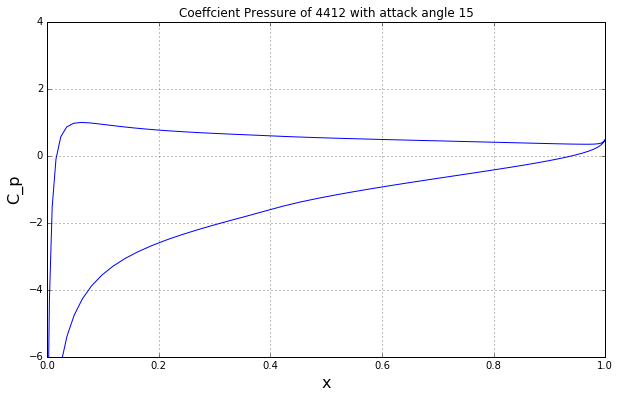

In [150]:
pxc=numpy.empty(N-1,dtype=float)
pcp=numpy.empty(N-1,dtype=float)
for i in range(N-1):
    pxc[i]=panel[i].xc
    pcp[i]=panel[i].cp
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.plot(pxc,pcp)
pyplot.gca().invert_yaxis()
pyplot.title('Coeffcient Pressure of 4412 with attack angle 15')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel("C_p", fontsize=16)
pyplot.xlim(0,1)
pyplot.ylim(-6, 4.0)